In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change dir to project dir
%cd /content/gdrive/MyDrive/Colab\ Data/COCO-Human-Pose

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Data/COCO-Human-Pose


In [ ]:
# (<5 mins)
# Setup train/val symlinks for this runtime
# puts them in /content/datasets/coco
# ensure you have added a Drive shortcut to the dataset in the root of your Drive
# this is necessary as the symlinks need a destination that exists
# the dataset is hosted here: https://drive.google.com/drive/folders/1EVsLBRwT2njNWOrmBAhDHvvB8qrd9pXT 
!unzip /content/gdrive/MyDrive/COCO/2017/train2017_symlinks-1000.zip -d /content
!unzip /content/gdrive/MyDrive/COCO/2017/val2017_symlinks-1000.zip -d /content

!ls /content/datasets/coco/train2017 | wc -l
!ls /content/datasets/coco/val2017 | wc -l

In [ ]:
# (10-20 mins)
# Populate the runtimes filesystem cache with dest directories for fast and predictable load times
import os
def print_files_in_dir(path):
  print(len(os.listdir(path)), " files at ", path)

for i in range(0,6):
  print_files_in_dir('/content/gdrive/MyDrive/COCO/2017/val2017_sub-1000/' + str(i))

for i in range(0,119):
    print_files_in_dir('/content/gdrive/MyDrive/COCO/2017/train2017_sub-1000/' + str(i))

In [6]:
# Example Usage of Data Generator
from constants import INPUT_DIM
from data_generator import DataGenerator

train_gen = DataGenerator("data/one_ann_min10kp_imgs.csv",
                          "/content/datasets/coco/",
                          INPUT_DIM,
                          batch_size=1,
                          shuffle=True)
# now let's train the model
#model.fit(train_gen, epochs=5, ...)

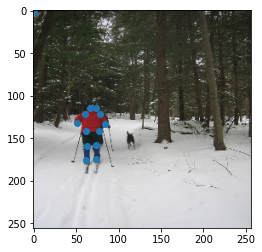

In [9]:
# Test the generator
import matplotlib.pyplot as plt

X, y = train_gen[4]

X, y = X[0], y[0]

xs = [v for i,v in enumerate(y) if i%3==0]
ys = [v for i,v in enumerate(y) if i%3==1]

plt.imshow(X)
plt.scatter(xs,ys)